# Assignment 2

### Authors:
* Niv Harmelech, 200327864
* Ben Eyal, 301841953

# Imports

In [1]:
# Q1
import itertools
import os.path
import re
import tarfile
import time
from collections import defaultdict
from glob import glob
from html.parser import HTMLParser
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from nltk import word_tokenize
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

# Q2

import string

import gensim
import nltk
from nltk.corpus import conll2002
from scipy.sparse import coo_matrix
from sklearn.base import TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder

# Q3

import tensorflow as tf
import tflearn
from keras.datasets import reuters
from tflearn.data_utils import pad_sequences, to_categorical
from tflearn.datasets import imdb


%matplotlib inline

C:\Users\Ben\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


Using TensorFlow backend.


# Q1. Document Classification

## Q1.1. Reuters Dataset Exploration 

### 1.

### Acknowledgements

In [2]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

### Prologue - Grump's Quest

Once upon a time there was a man called Ronald Grump. He was the president of the United States of Scramerica. Grump hated many things. So many things, in fact, that he could not fit them all into his memory. One of these things was FAKE NEWS, which stands for "written-media-which-says-things-Grump-does-not-like". Trust me, it's an acronym. Anyway, one such supplier of FAKE NEWS was Reuters, and Grump wanted to see just how much FAKE NEWS Reuters had. Grump's advisers told him it was approximately "one metric fuckton" (1,000 fuckilograms), but Grump also hated metric units, so he had no idea what they meant, and so Grump set out on a journey to discover how much FAKE NEWS does Reuters really hold.

### Chapter I - Reuters Recon

As president Grump's memory is nothing to write home about, he sends for the only man who can help him: Dave. Dave is an all-around nice guy, and Grump will kill him if he won't help, so not too many choices there. Poor Dave.

With a pen in hand, Dave explained how Grump can learn all he needs about Reuters
without making his head explode: "It is really simple, Mr. President! First I need to teach you how to read!" (because apparently, in Scramerica, the only thing you need in order to run for president is a Scramerican citizenship, and a somewhat regular pulse).

#### Grump's Reading Lesson a.k.a Reuters Dataset Parser

This is a very boring lesson, and you might wish to [skip ahead](#generator).

The dataset consists of HTML-like markup files, and `ReutersParser` is just a very simple implementation of Python's `HTMLParser`, as per the parent class' documentation.

In [3]:
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""

<a id="generator"></a>
#### Dave's Handy-Dandy Code a.k.a Reuters Dataset Generator

After a very long, tedious, and annoying reading lesson, Dave continued: "Now that you can read, we need to make sure we don't bite more data than we can chew, so I made this nifty little piece of code that brings us Reuters' documents one-by-one!"

In [4]:
def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/reuters21578.tar.gz'
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" % data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb), end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path, reporthook=progress)
        
        print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

### Chapter II - Know Your Enemy

With the power of reading under his belt, and Dave by his side, Grump was now ready to tackle the dataset. Or so he thought. Which isn't surprising, being he's an idiot.

Dave wanted to start easy with the big boss, and knowing of Grump's past in real-estate, decided to teach him how to tell if a document is about acquisitions/merges, or about anything else.

In [5]:
all_classes = np.array([0, 1])
positive_class = 'acq'

First, he needed to get those documents flowing:

In [6]:
data_stream = stream_reuters_documents()

Then, he needed to explain to Grump what is about to happen.

"Mr. President, I need you to concentrate. We're going to play a game: I'll give you many many words, and you give me a number between 0 and 262,144 for each word, got that? Oh, and try really hard not to repeat the same number twice!"

In [7]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18, non_negative=True)

### Chapter III - Choose Your Own Adventure!

Yes, kids, we are going to choose how Grump's brain is going to work!

Because we are very optimistic, let's suppose that Grump's brain is running one of these four algorithms:

* Stochastic Gradient Descent (SGD)
* Perceptron
* Multinomial Naive Bayes
* Online Passive-Aggressive

What's special about the above algorithms is that they are online algorithms, meaning one can feed them training data in batches, and not all at once. Grump's brain is going to learn to tell between documents about acquisitions/mergers and documents about anything else. In our small simulation, instead of "learn", we will say "partial fit".

In [8]:
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

These next two functions are responsible for separating the flow of documents to constant-sized batches. `iter_minibatches` is a generator of batches, each batch produced from `get_minibatch`. These make a sort of "treadmill" of information, right into Grump's brain.

In [9]:
def get_minibatch(doc_iter, size, pos_class=positive_class):
    data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)

In order for Dave to monitor the success of Grump's training, he needs to put aside some documents, and hide them from Grump. Later, when the training is finished, Dave can test Grump using these secret documents. He's also keeping tabs on how long it takes to train Grump, because Dave is paid hourly.

In [10]:
test_stats = {'n_test': 0, 'n_test_pos': 0}

n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += y_test.size
test_stats['n_test_pos'] += y_test.sum()
print("Test set is %d documents (%d positive)" % (y_test.size, y_test.sum()))

Test set is 878 documents (108 positive)


Nothing to see here, just some bells and whistles...

In [11]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier :  " % (cls_name,)
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

Okay, now each of the learners described above will learn to tell between acquisitions/mergers and other documents by learning from a batch of example at every step.

In [12]:
cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0,
             'n_train_pos': 0,
             'accuracy': 0.0,
             'accuracy_history': [(0, 0)],
             't0': time.time(),
             'runtime_history': [(0, 0)],
             'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

minibatch_size = 1000

minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # Just some statistics for Dave
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'], cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'], total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

      NB Multinomial classifier :     966 train docs (    88 positive)    878 test docs (   108 positive) accuracy: 0.877 in 0.65s ( 1477 docs/s)
                 SGD classifier :     966 train docs (    88 positive)    878 test docs (   108 positive) accuracy: 0.891 in 0.67s ( 1434 docs/s)
  Passive-Aggressive classifier :     966 train docs (    88 positive)    878 test docs (   108 positive) accuracy: 0.910 in 0.68s ( 1427 docs/s)
          Perceptron classifier :     966 train docs (    88 positive)    878 test docs (   108 positive) accuracy: 0.904 in 0.68s ( 1421 docs/s)


      NB Multinomial classifier :    3889 train docs (   483 positive)    878 test docs (   108 positive) accuracy: 0.884 in 2.71s ( 1435 docs/s)
                 SGD classifier :    3889 train docs (   483 positive)    878 test docs (   108 positive) accuracy: 0.948 in 2.71s ( 1434 docs/s)
  Passive-Aggressive classifier :    3889 train docs (   483 positive)    878 test docs (   108 positive) accuracy: 0.952 

#### Pretty Colors!

Let's see which of the algorithms is the best algorithm suitable for Grump's brain, and what a better way to decide if not with pretty colors and charts and graphs! It's like an educational acid trip!

First, a little tinkering...

In [13]:
rcParams['legend.fontsize'] = 10

We take the names of the four algorithms above:

In [14]:
cls_names = list(sorted(cls_stats.keys()))

And now we can start doing some pretty stuff! First, we'll see how accuracy improves as a function of both the number of training examples, and runtime:

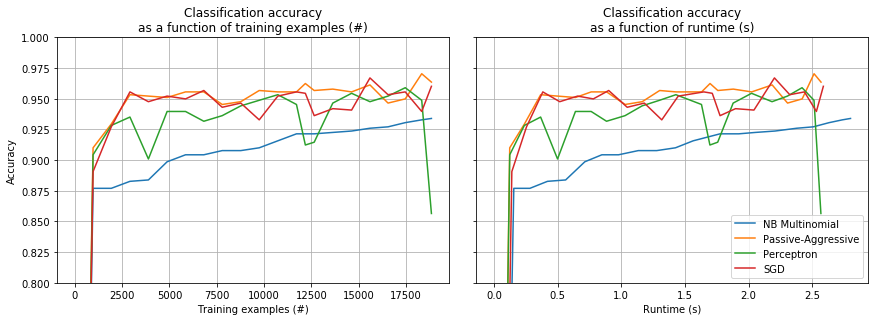

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(12)
f.tight_layout()

def plot_accuracy(axes, key, xlabel):
    axes.set_title('Classification accuracy\nas a function of %s' % (xlabel,))
    axes.set_xlabel(xlabel.capitalize())
    axes.grid(True)
    for _, stats in sorted(cls_stats.items()):
        y, x = [np.array(z) for z in zip(*stats[key])]
        axes.plot(x, y)

plot_accuracy(ax1, 'accuracy_history', 'training examples (#)')
plot_accuracy(ax2, 'runtime_history', 'runtime (s)')
ax1.set_ylim((0.8, 1))
ax1.set_ylabel('Accuracy')
ax2.legend(cls_names, loc='best');

Nice. We see the online Passive-Aggressive algorithm achieves the best accuracy, although SGD and Perceptron are close by. Multinomial naive Bayes is... it's getting there...

Now let's see how long does it take to fit the data for each algorithm. Although vectorization is not part of the learning process, it does incur a heavy overhead, so we add that time to the graph.

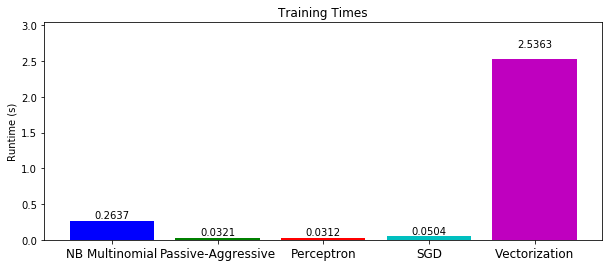

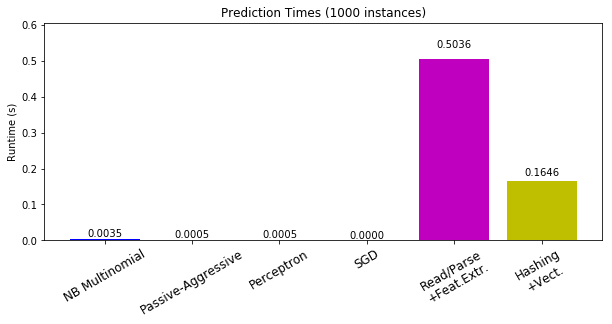

In [16]:
def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.05 * height, '%.4f' % height, ha='center', va='bottom')


bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot fitting times
plt.figure()
fig = plt.gcf()
fig.set_figwidth(10)
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])
cls_runtime.append(total_vect_time)
cls_names_with_vectorization = cls_names + ['Vectorization']
rectangles = plt.bar(range(len(cls_names_with_vectorization)), cls_runtime, color=bar_colors)
plt.xticks(range(5), cls_names_with_vectorization, fontsize=12)
plt.ylim((0, max(cls_runtime) * 1.2))
plt.ylabel('Runtime (s)')
plt.title('Training Times')
autolabel(rectangles)

# Plot prediction times
plt.figure()
fig = plt.gcf()
fig.set_figwidth(10)
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_runtime.append(vectorizing_time)
cls_names_with_overhead = cls_names + ['Read/Parse\n+Feat.Extr.', 'Hashing\n+Vect.']
rectangles = plt.bar(range(len(cls_names_with_overhead)), cls_runtime, color=bar_colors)
plt.xticks(range(6), cls_names_with_overhead, fontsize=12)
plt.setp(plt.xticks()[1], rotation=30)
plt.ylim((0, max(cls_runtime) * 1.2))
plt.ylabel('Runtime (s)')
plt.title('Prediction Times (%d instances)' % (n_test_documents,))
autolabel(rectangles)

### Epilogue

Although not by much, we choose an online passive-aggressive brain for Grump. Apparently, his problem is that he's mostly just aggressive

(Un)fortunately, all this learning made Grump forget what he was doing as president, so he quit and let Dave take charge for a while, until someone who knows what the hell s/he's doing comes along.

### THE END

### 2.

In [17]:
data_stream = stream_reuters_documents()

stats = defaultdict(int)
count = 0
for doc in data_stream:
    count += 1
    for topic in doc.get('topics', []):
        stats[topic] += 1

desc_stats = pd.Series(stats, dtype=int).describe()
desc_stats['unique_count'] = count

print("Reuters-21578 Statsitics")
print("========================")
print("""No. of documents: %(unique_count)d
No. of topics:    %(count)d
Mean:             %(mean).2f
Std. deviation:   %(std).2f
Min:              %(min)d
Max:              %(max)d
""" % desc_stats)

Reuters-21578 Statsitics
No. of documents: 21578
No. of topics:    445
Mean:             89.87
Std. deviation:   644.66
Min:              1
Max:              12542



### 3.

It's easy to count characters, but since "word" is not well-defined in the question, we'll use NLTK's `word_tokenize` for word splitting.

In [18]:
data_stream = stream_reuters_documents()

counts = defaultdict(int)

for docs, _ in iter_minibatches(data_stream, 1000):
    for doc in docs:
        counts['char'] += len(doc)
        counts['word'] += len(word_tokenize(doc))

print("The dataset has {char:,} characters and {word:,} words.".format(**counts))

The dataset has 16,003,823 characters and 2,940,996 words.


### 4.

Scikit-Learn has a number of algorithms that support incremental, or online, learning. This means the algorithm can train on a dataset by seeing a small batch in each iteration. This allows for out-of-core learning, since it doesn't require the entire dataset be present in memory. The algorithms that support the `partial_fit` method in Scikit-Learn are:

* Classification
    * `sklearn.naive_bayes.MultinomialNB`
    * `sklearn.naive_bayes.BernoulliNB`
    * `sklearn.linear_model.Perceptron`
    * `sklearn.linear_model.SGDClassifier`
    * `sklearn.linear_model.PassiveAggressiveClassifier`

* Regression
    * `sklearn.linear_model.SGDRegressor`
    * `sklearn.linear_model.PassiveAggressiveRegressor`

* Clustering
    * `sklearn.cluster.MiniBatchKMeans`

* Decomposition / feature Extraction
    * `sklearn.decomposition.MiniBatchDictionaryLearning`
    * `sklearn.decomposition.IncrementalPCA`
    * `sklearn.decomposition.LatentDirichletAllocation`
    * `sklearn.cluster.MiniBatchKMeans`


### 5.

The hashing vectorizer used in the example takes a number of features `n_features` as an argument (and many more, which weren't used in the example), and projects each document to a `n_features`-dimensional vector space. Unlike `DictVectorizer` or `CountVectorizer`, this vectorizer does not have a `fit` method, only `transform`, because the whole point is that one can use the vectorizer when doing online learning: there's a good chance that later batches will have words that previous batches did not, and so early fitting would be wrong.

## Q2. Sequence Labelling for Named Entity Recognition

### Dataset

In [19]:
etr = conll2002.iob_sents('esp.train') # In Spanish
eta = conll2002.iob_sents('esp.testa') # In Spanish
etb = conll2002.iob_sents('esp.testb') # In Spanish

dtr = conll2002.iob_sents('ned.train') # In Dutch
dta = conll2002.iob_sents('ned.testa') # In Dutch
dtb = conll2002.iob_sents('ned.testb') # In Dutch

### Q2.1 Features

We start by creating our own scikit-learn transformer which transforms the CoNLL-2002 dataset to a list of feature dictionaries. Creating a transformer requires only to inherit `TransformerMixin` and implement `fit` and `transform`.

In [20]:
class NERFeatureExtractor(TransformerMixin):
    def transform(self, X):
        ort = {
            'number': lambda s: s.isnumeric(),
            'contains-digit': lambda s: any(c.isdigit() for c in s),
            'contains-hyphen': lambda s: '-' in s,
            'capitalized': lambda s: s.istitle(),
            'all-capitals': lambda s: s.isupper(),
            'punctuation': lambda s: s in string.punctuation,
        }
        all_features = []
        for sent in X:
            for i, (word, postag) in enumerate(sent):
                for value, pred in ort.items():
                    if pred(word):
                        ort_value = value
                        break
                else:
                    ort_value = 'regular'

                features = {
                    'word': word.lower(),
                    'postag': postag,
                    'ort': ort_value,
                    'prefix1': word[:1],
                    'prefix2': word[:2],
                    'prefix3': word[:3],
                    'suffix1': word[-1:],
                    'suffix2': word[-2:],
                    'suffix3': word[-3:],
                }
                
                if i > 0:
                    prev_word, prev_postag = sent[i-1]
                    features.update({'prev_word': prev_word,
                                     'prev_postag': prev_postag})
                else:
                    features.update({'prev_word': '-START-'})
                
                if i < len(sent) - 1:
                    next_word, next_postag = sent[i+1]
                    features.update({'next_word': next_word,
                                     'next_postag': next_postag})
                else:
                    features.update({'next_word': '-END-'})
                
                all_features.append(features)
        return all_features
    
    def fit(self, X, y=None):
        return self

We now create our training, development, and test sets. Since NER is a multiclass classification problem, and our labels are categorical, we use scikit-learn's `LabelEncoder` to learn the tags in the training set, and transform each label vector to a numerical counterpart.

In [21]:
def make_feature_extractor():
    return Pipeline([('get_features', NERFeatureExtractor()),
                     ('vectorize', DictVectorizer())])


def get_labels(dataset):
    return [label for sent in dataset for _, _, label in sent]


def unlabel(dataset):
    return [[(word, postag) for word, postag, _ in sent] for sent in dataset]


def get_label_encoder(dataset):
    return LabelEncoder().fit(get_labels(dataset))


# Spanish
esp_fe = make_feature_extractor()
esp_le = get_label_encoder(etr)

X_train_esp = esp_fe.fit_transform(unlabel(etr))
y_train_esp = esp_le.fit_transform(get_labels(etr))

X_dev_esp = esp_fe.transform(unlabel(eta))
y_dev_esp = esp_le.transform(get_labels(eta))

X_test_esp = esp_fe.transform(unlabel(etb))
y_test_esp = esp_le.transform(get_labels(etb))

# Dutch
ned_fe = make_feature_extractor()
ned_le = get_label_encoder(dtr)

X_train_ned = ned_fe.fit_transform(unlabel(dtr))
y_train_ned = ned_le.fit_transform(get_labels(dtr))

X_dev_ned = ned_fe.transform(unlabel(dta))
y_dev_ned = ned_le.transform(get_labels(dta))

X_test_ned = ned_fe.transform(unlabel(dtb))
y_test_ned = ned_le.transform(get_labels(dtb))

We will be using a logistic regression classifier, which has a regularization parameter `C`. To optimize the parameter, we'll iterate over several values for `C`, train the classifier, and test it on `testa`, which is the development set.

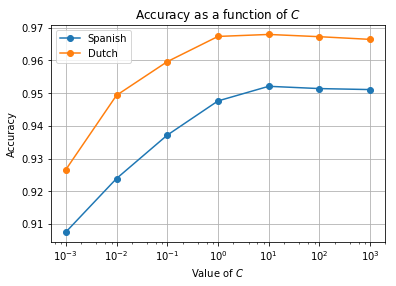

In [22]:
def optimize_C(X_train, y_train, X_dev, y_dev):
    Cs = [10 ** i for i in range(-3, 4)]
    scores = []
    for C in Cs:
        clf = LogisticRegression(C=C).fit(X_train, y_train)
        scores.append(clf.score(X_dev, y_dev))
    plt.semilogx(Cs, scores, linestyle='-', marker='o')
    C_opt = max(Cs, key=lambda C: dict(zip(Cs, scores))[C])
    return C_opt
    

plt.grid(True)
plt.title('Accuracy as a function of $C$')
plt.xlabel('Value of $C$')
plt.ylabel('Accuracy')
C_opt_esp = optimize_C(X_train_esp, y_train_esp, X_dev_esp, y_dev_esp)
C_opt_ned = optimize_C(X_train_ned, y_train_ned, X_dev_ned, y_dev_ned)
plt.legend(['Spanish', 'Dutch'], loc='best');

Okay, we got the optimal `C`s, now let's see how we do on the test set!

In [23]:
def make_classifier(C):
    return Pipeline([('get_features', NERFeatureExtractor()),
                     ('vectorize', DictVectorizer()),
                     ('classify', LogisticRegression(C=C))])

spanish_clf = make_classifier(C_opt_esp)
spanish_clf.fit(unlabel(etr), y_train_esp)
print("Spanish model accuracy: %.2f%%" % (100 * spanish_clf.score(unlabel(etb), y_test_esp),))

dutch_clf = make_classifier(C_opt_ned)
dutch_clf.fit(unlabel(dtr), y_train_ned)
print("Dutch model accuracy: %.2f%%" % (100 * dutch_clf.score(unlabel(dtb), y_test_ned),))

Spanish model accuracy: 96.19%
Dutch model accuracy: 97.56%


Good enough for science!

Please scroll to the next cell, nothing to see here but functions...

In [24]:
def f1_precision_recall(clf, le, test):
    y_pred = clf.predict(unlabel(test))
    y_true = le.transform(get_labels(test))
    stats_per_label = {}
    for label in set(y_true):
        # Fucking NumPy, so good...
        tp = ((y_pred == label) & (y_true == label)).sum()
        tn = ((y_pred != label) & (y_true != label)).sum()
        fp = ((y_pred == label) & (y_true != label)).sum()
        fn = ((y_pred != label) & (y_true == label)).sum()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * precision * recall / (precision + recall)
        stats_per_label[label] = {'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}
    df = pd.DataFrame(stats_per_label).sort_values('F1 Score', axis=1).T
    df.index = le.classes_
    return df[['Precision', 'Recall','F1 Score']]


def confusion_matrix(clf, le, test):
    y_pred = clf.predict(unlabel(test))
    y_true = le.transform(get_labels(test))

    labels = np.array(list(sorted(set(y_true) | set(y_pred))))

    sample_weight = np.ones(y_true.shape[0], dtype=np.int)

    n_labels = labels.size
    label_to_ind = dict((y, x) for x, y in enumerate(labels))
    y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
    y_true = np.array([label_to_ind.get(x, n_labels + 1) for x in y_true])
    ind = np.logical_and(y_pred < n_labels, y_true < n_labels)
    y_pred = y_pred[ind]
    y_true = y_true[ind]
    sample_weight = sample_weight[ind]

    CM = coo_matrix((sample_weight, (y_true, y_pred)), shape=(n_labels, n_labels)).toarray()

    return CM, labels


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now let's do some "nice-on-the-eyes" things such as precision, recall, F1 score, and a pretty confusion matrix! Hooray for confusion matrix!

First, Spanish:

,Precision,Recall,F1 Score
B-LOC,0.593567,0.364452,0.451613
B-MISC,0.535836,0.463127,0.496835
B-ORG,0.685590,0.483077,0.566787
B-PER,0.733483,0.593297,0.655984
I-LOC,0.766932,0.710332,0.737548
I-MISC,0.798644,0.841429,0.819478
I-ORG,0.828571,0.868027,0.847841
I-PER,0.812233,0.900631,0.854151
O,0.987321,0.997531,0.992400


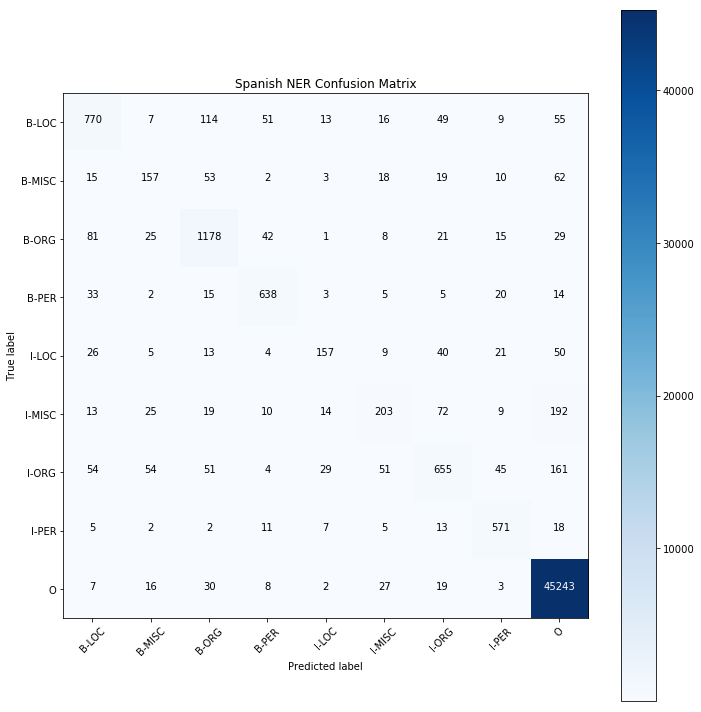

In [25]:
cm, labels = confusion_matrix(spanish_clf, esp_le, etb)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, esp_le.classes_, title='Spanish NER Confusion Matrix')
f1_precision_recall(spanish_clf, esp_le, etb)

Last (and maybe least, I don't judge), Dutch:

,Precision,Recall,F1 Score
B-LOC,0.617117,0.334146,0.433544
B-MISC,0.530612,0.530612,0.530612
B-ORG,0.804749,0.553539,0.655914
B-PER,0.766798,0.659864,0.709324
I-LOC,0.801914,0.705981,0.750896
I-MISC,0.761084,0.844262,0.800518
I-ORG,0.832425,0.789406,0.810345
I-PER,0.751817,0.897150,0.818079
O,0.992757,0.998875,0.995806


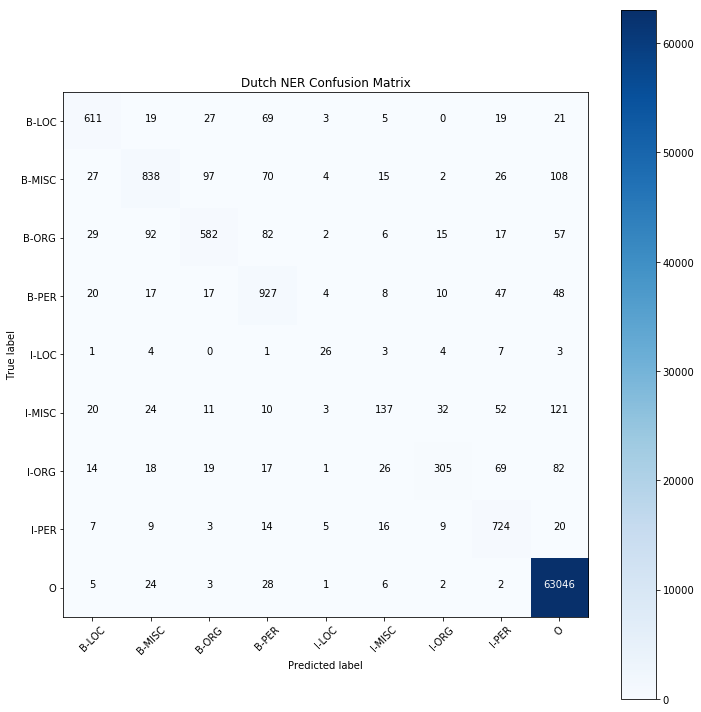

In [26]:
cm, labels = confusion_matrix(dutch_clf, ned_le, dtb)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, ned_le.classes_, title='Dutch NER Confusion Matrix')
f1_precision_recall(dutch_clf, ned_le, dtb)

Wow. That actually kinda sucks. Yay, we know when we're **not** in a named entity. Go home, everybody, nothing to see here but shame...

### Q2.2 HMM and Viterbi

#### 2.2.1

In [27]:
class HiddenMarkovModel:
    def __init__(self, train, gamma=0.5):
        train = [[tuple('***'), tuple('***')] + sent + [('STOP',) * 3] for sent in train]
        tags = [tag for sent in train for _, _, tag in sent]
        tag_cfd = nltk.ConditionalFreqDist([((u, v), w) for u, v, w in nltk.trigrams(tags)])
        tag_words_cfd = nltk.ConditionalFreqDist([(tag, word) for sent in train for word, _, tag in sent])
        
        self.tags = frozenset(tags)
        self.q = nltk.ConditionalProbDist(tag_cfd, nltk.MLEProbDist)
        self.e = nltk.ConditionalProbDist(tag_words_cfd, lambda fd: nltk.LidstoneProbDist(fd, gamma))
        self.tag2idx = {tag: i for tag, i in zip(self.tags, range(len(self.tags)))}
        self.idx2tag = {i: tag for tag, i in zip(self.tags, range(len(self.tags)))}

    def viterbi(self, sent):
        x = sent
        n = len(sent)
        K = {i: self.tags for i in range(n + 1)}
        K[-1] = K[0] = {'*'}
        pi, bp = {}, {}
        pi[0, '*', '*'] = 0
        for k in range(1, n + 1):
            for u, v in itertools.product(K[k-1], K[k]):
                max_, argmax_ = max([(pi[k - 1, w, u] + self.q[w, u].logprob(v) + self.e[v].logprob(x[k - 1]), w)
                                     for w in K[k - 2]])
                pi[k, u, v] = max_
                bp[k, u, v] = argmax_
        y = [None] * (n + 1)
        y[-2:] = max([[u, v] for u, v in itertools.product(K[n-1], K[n])],
                     key=lambda uv: pi[n, uv[0], uv[1]] + self.q[uv[0], uv[1]].logprob('STOP'))
        for k in range(n - 2, 0, -1):
            y[k] = bp[k + 2, y[k + 1], y[k + 2]]
        return y[1:]
    
    def evaluate(self, test):
        sents = [[w for w, _, _ in sent] for sent in test]
        tags = [[t for _, _, t in sent] for sent in test]
        y_true = [self.tag2idx[t] for sent in tags for t in sent]
        y_pred = [self.tag2idx[t] for sent in sents for t in self.viterbi(sent)]
        return np.equal(y_true, y_pred).mean()

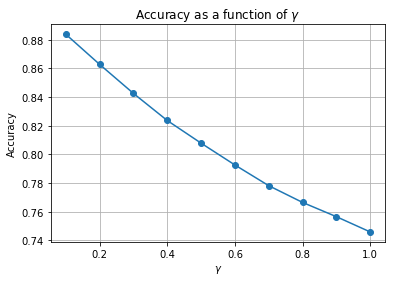

In [28]:
gammas = np.linspace(0.1, 1, 10)
scores = []
for gamma in gammas:
    hmm = HiddenMarkovModel(etr, gamma=gamma)
    scores.append(hmm.evaluate(eta))
plt.title('Accuracy as a function of $\gamma$')
plt.xlabel('$\gamma$')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(gammas, scores, linestyle='-', marker='o');

In [29]:
gamma_opt = max(gammas, key=lambda gamma: dict(zip(gammas, scores))[gamma])
hmm = HiddenMarkovModel(etr, gamma=gamma_opt)
print('HMM achieves an accuracy of %.2f%%.' % (100 * hmm.evaluate(etb)))

HMM achieves an accuracy of 91.68%.


### Q2.3 Using Word Embeddings

We'll load some trained word2vec models for Spanish and Dutch, and use `init_sims(replace=True)` because Gensim-Man says it takes less memory.

In [30]:
esp_model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('sbw_vectors.bin', binary=True)
esp_model.init_sims(replace=True)

ned_model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('dutch_combined-320.txt')
ned_model.init_sims(replace=True)

Now we define a new transformer to use in our pipeline: this transformer takes the word form features, and constructs a 900-dimensional vector made from the vector for the previous word, the current word, and the next word. If a word does not exist in the model, we put zero vector instead. We also tried averaging the three vectors to construct one 300-dimensional vector, and it didn't do as well as concatenation.

In [33]:
class EmbeddingsExtractor(TransformerMixin):
    def __init__(self, embeddings_model):
        self.model = embeddings_model
        self.words = set(self.model.index2word)
        self.size = self.model.syn0.shape[1]
    
    def transform(self, X):
        embeddings = []
        for sent in X:
            for i, (word, _) in enumerate(sent):
                embedding = np.zeros((3*self.size,))
                
                if i > 0 and sent[i-1][0] in self.words:
                    embedding[:self.size] = self.model[sent[i-1][0]]
                if word in self.words and word not in ('-START-', '-END-'):
                    embedding[self.size:2*self.size] = self.model[word]
                if i < len(sent) - 1 and sent[i+1][0] in self.words:
                    embedding[2*self.size:] = self.model[sent[i+1][0]]
                
                embeddings.append(embedding)
        return embeddings
    
    def fit(self, X, y=None):
        return self

Like before, it's time to see the classifiers' score on the test set:

In [34]:
def make_classifier_with_embeddings(C, word2vec_model):
    return Pipeline([
        ('get_features', FeatureUnion([
            ('word_forms_and_tags', Pipeline([
                ('extract', NERFeatureExtractor()),
                ('vectorize', DictVectorizer())
            ])),
            ('word_embeddings', EmbeddingsExtractor(word2vec_model))
        ])),
        ('classify', LogisticRegression(C=C))
    ])

w2v_spanish_clf = make_classifier_with_embeddings(C_opt_esp, esp_model)
w2v_spanish_clf.fit(unlabel(etr), y_train_esp)
print("Spanish model w/embeddings accuracy: %.2f%%" % (100 * w2v_spanish_clf.score(unlabel(etb), y_test_esp),))
del esp_model

w2v_dutch_clf = make_classifier_with_embeddings(C_opt_ned, ned_model)
w2v_dutch_clf.fit(unlabel(dtr), y_train_ned)
print("Dutch model w/embeddings accuracy: %.2f%%" % (100 * w2v_dutch_clf.score(unlabel(dtb), y_test_ned),))
del ned_model

Spanish model w/embeddings accuracy: 96.79%
Dutch model w/embeddings accuracy: 97.71%


Wow. Talk about a letdown, eh? Less than 0.5% difference...

Oh well, you know the drill: precision, recall, F1 score, and pretty colors.

This time, Dutch goes first:

,Precision,Recall,F1 Score
B-LOC,0.631799,0.368293,0.465331
B-MISC,0.619048,0.530612,0.571429
B-ORG,0.790155,0.553539,0.651014
B-PER,0.776610,0.670068,0.719416
I-LOC,0.821497,0.721146,0.768057
I-MISC,0.782285,0.860656,0.819601
I-ORG,0.837116,0.810078,0.823375
I-PER,0.781152,0.924411,0.846765
O,0.992991,0.998907,0.995940


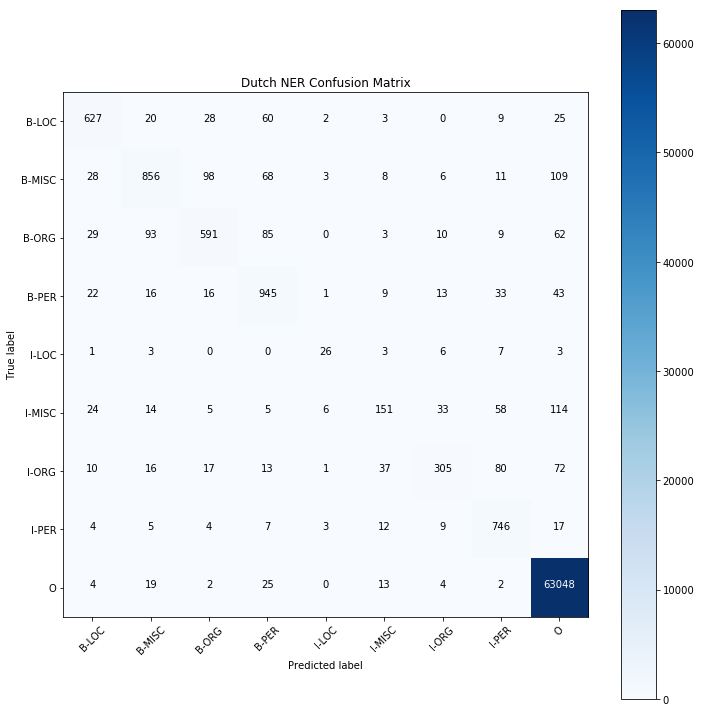

In [35]:
cm, labels = confusion_matrix(w2v_dutch_clf, ned_le, dtb)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, ned_le.classes_, title='Dutch NER Confusion Matrix')
f1_precision_recall(w2v_dutch_clf, ned_le, dtb)

Spanish:

,Precision,Recall,F1 Score
B-LOC,0.594937,0.421903,0.493697
B-MISC,0.538710,0.492625,0.514638
B-ORG,0.692913,0.541538,0.607945
B-PER,0.770153,0.640399,0.699308
I-LOC,0.786389,0.767528,0.776844
I-MISC,0.820240,0.880000,0.849070
I-ORG,0.893179,0.944218,0.917989
I-PER,0.908397,0.938486,0.923196
O,0.990737,0.997486,0.994100


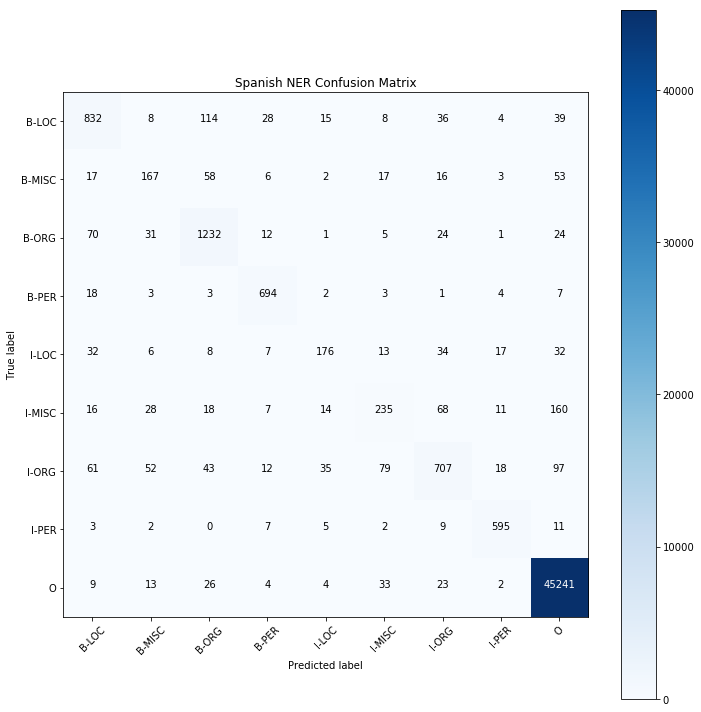

In [36]:
cm, labels = confusion_matrix(w2v_spanish_clf, esp_le, etb)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, esp_le.classes_, title='Spanish NER Confusion Matrix')
f1_precision_recall(w2v_spanish_clf, esp_le, etb)

## Q3. RNN (LSTM) for Document Classification

### Q3.1 Run the example

In [37]:
# IMDB Dataset loading
(X_train, y_train), (X_val, y_val), (X_test, y_test) = imdb.load_data(path='imdb.pkl', n_words=10000, valid_portion=0.1)

# Data preprocessing

## Sequence padding
X_train = pad_sequences(X_train, maxlen=100, value=0.)
X_val = pad_sequences(X_val, maxlen=100, value=0.)
X_test = pad_sequences(X_test, maxlen=100, value=0.)

## Converting labels to binary vectors
y_train = to_categorical(y_train, nb_classes=2)
y_val = to_categorical(y_val, nb_classes=2)
y_test = to_categorical(y_test, nb_classes=2)

# Network building

net = tflearn.input_data([None, 100])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

# Training

lstm_model = tflearn.DNN(net)
lstm_model.fit(X_train, y_train, validation_set=(X_val, y_val), show_metric=True, batch_size=32, run_id='lstm')

Training Step: 7039  | total loss: 0.09047 | time: 48.412s
| Adam | epoch: 010 | loss: 0.09047 - acc: 0.9803 -- iter: 22496/22500
Training Step: 7040  | total loss: 0.09623 | time: 49.893s
| Adam | epoch: 010 | loss: 0.09623 - acc: 0.9792 | val_loss: 0.69106 - val_acc: 0.8124 -- iter: 22500/22500
--


In [38]:
print('LSTM score on IMDb test set: %.2f%%' % (100 * lstm_model.evaluate(X_test, y_test, batch_size=32)[0]))

LSTM score on IMDb test set: 76.72%


#### TensorBoard

##### Accuracy:

![](q31_accuracy.png)

##### Loss:

![](q31_loss.png)

##### Graphs:

![](q31_graphs.png)

### Q3.2 MLP Baseline

In [39]:
def onehot(seqs):
    X = np.zeros((len(seqs), 10000), dtype=np.uint8)
    for i, seq in enumerate(seqs):
        for j in seq:
            if j < 10000:
                X[i, j] = 1
    return X


# IMDB Dataset loading
(X_train, y_train), (X_val, y_val), (X_test, y_test) = imdb.load_data(path='imdb.pkl', n_words=10000, valid_portion=0.1)

# Data preprocessing

## One-Hot encoding
X_train = onehot(X_train)
X_val = onehot(X_val)
X_test = onehot(X_test)

## Converting labels to binary vectors
y_train = to_categorical(y_train, nb_classes=2)
y_val = to_categorical(y_val, nb_classes=2)
y_test = to_categorical(y_test, nb_classes=2)

# Network building

tf.reset_default_graph()

net = tflearn.input_data([None, 10000])
net = tflearn.fully_connected(net, 256, activation='relu')
net = tflearn.dropout(net, keep_prob=0.2)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

# Training (only 2 epochs, it overfits super-fast)

mlp_model = tflearn.DNN(net)
mlp_model.fit(X_train, y_train, n_epoch=2, validation_set=(X_val, y_val), show_metric=True, batch_size=32, run_id='mlp')

Training Step: 1407  | total loss: 0.21843 | time: 5.994s
| Adam | epoch: 002 | loss: 0.21843 - acc: 0.9024 -- iter: 22496/22500
Training Step: 1408  | total loss: 0.21779 | time: 7.074s
| Adam | epoch: 002 | loss: 0.21779 - acc: 0.9028 | val_loss: 0.26319 - val_acc: 0.8944 -- iter: 22500/22500
--


In [40]:
print('Multi-layer Perceptron score on IMDb test set: %.2f%%' % (100 * mlp_model.evaluate(X_test, y_test, batch_size=32)[0]))

Multi-layer Perceptron score on IMDb test set: 88.68%


### Q3.3 Reuters Classification in TFLearn

#### 3.3.1

First, create the index $\leftrightarrow$ word mapping.

In [41]:
WORD2ID = reuters.get_word_index()
ID2WORD = {id_: word for word, id_ in WORD2ID.items()}

We have to account for the fact that some words have no ID, and some IDs don't have words (e.g. zero).

In [42]:
def encode_doc(string):
    words = word_tokenize(string)
    return [WORD2ID.get(w, 0) for w in words]


def decode_doc(ids):
    return [ID2WORD.get(id_, 'UNK') for id_ in ids]

#### 3.3.2

Let's prepare our dataset. Unlike IMDb, we have to create a validation set ourselves. We do that by taking half of the test set.

What is similar to IMDb is how we handle our input: we want no more than the top 10,000 words to appear in the training set, and the sequences must be no longer than 100 words.

In [43]:
# Reuters Dataset loading
(X_train, y_train), (X_test, y_test) = reuters.load_data(nb_words=10000, maxlen=100)
X_val = X_test[:len(X_test)//2]
y_val = y_test[:len(y_test)//2]
X_test = X_test[len(X_test)//2:]
y_test = y_test[len(y_test)//2:]

# Data preprocessing

## Sequence padding
X_train = pad_sequences(X_train, maxlen=100)
X_val = pad_sequences(X_val, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

## Converting labels to vectors
nb_classes = np.max(y_train) + 1
y_train = to_categorical(y_train, nb_classes=nb_classes)
y_val = to_categorical(y_val, nb_classes=nb_classes)
y_test = to_categorical(y_test, nb_classes=nb_classes)

We blatantly copy TFLearn's LSTM implementation for IMDb and use it for Reuters.

In [44]:
tf.reset_default_graph()

# Network building
net = tflearn.input_data([None, 100])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, nb_classes, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net)
model.fit(X_train, y_train, n_epoch=10, validation_set=(X_val, y_val), show_metric=True, batch_size=32, run_id='reuters_lstm')

Training Step: 1499  | total loss: 1.30599 | time: 10.341s
| Adam | epoch: 010 | loss: 1.30599 - acc: 0.7185 -- iter: 4768/4777
Training Step: 1500  | total loss: 1.37356 | time: 11.415s
| Adam | epoch: 010 | loss: 1.37356 - acc: 0.6967 | val_loss: 1.33013 - val_acc: 0.7119 -- iter: 4777/4777
--


In [45]:
print('LSTM score on Reuters test set: %.2f%%' % (100 * model.evaluate(X_test, y_test, batch_size=32)[0]))

LSTM score on Reuters test set: 66.22%


#### TensorBoard

##### Accuracy:

![](q332_accuracy.png)

##### Loss:

![](q332_loss.png)

##### Graphs:

![](q332_graphs.png)

That kinda sucks.

#### 3.3.3

Not much to say here. We get a document, send it through our NN, and we get a probability distribution (because of the softmax activation). We take the index of the largest probability, which is the predicted class of the document.

In [46]:
def classify_doc(string):
    return np.array(model.predict([string])[0]).argmax()

#### 3.3.4

Self-documenting code FTW.

In [47]:
(X, y), _ = reuters.load_data(test_split=0)

stats = []
for i, (doc, cls) in enumerate(zip(X, y)):
    stats.append({
        'number_of_words': len(doc),
        'class': cls
    })
pd.DataFrame(stats).groupby('class').describe()

number_of_words
class                       
0     count        67.000000
      mean        230.149254
      std         191.941930
      min          37.000000
      25%          84.000000
      50%         169.000000
      75%         288.000000
      max         863.000000
1     count       537.000000
      mean        188.426443
      std         199.344791
      min          15.000000
      25%          90.000000
      50%         122.000000
      75%         222.000000
      max        2376.000000
2     count        94.000000
      mean        177.627660
      std         136.563899
      min          26.000000
      25%          84.000000
      50%         130.000000
      75%         228.750000
      max         712.000000
3     count      3972.000000
      mean         86.992951
      std          88.175950
      min           2.000000
      25%          37.000000
      50%          63.000000
...                      ...
42    std         117.188452
      min          47.000000
      25%         101.750000
      50%         198.500000
      75%         307.250000
      max         459.000000
43    count        27.000000
      mean        161.037037
      std         131.851747
      min          50.000000
      25%          77.500000
      50%          93.000000
      75%         221.500000
      max         490.000000
44    count        17.000000
      mean        110.764706
      std         122.915891
      min          59.000000
      25%          59.000000
      50%          59.000000
      75%          85.000000
      max         558.000000
45    count        19.000000
      mean        159.157895
      std         141.791813
      min          32.000000
      25%          63.500000
      50%         132.000000
      75%         199.500000
      max         624.000000

[368 rows x 1 columns]

#### 3.3.5

Okay, we try to use Google News' pre-trained word2vec model as an embedding layer, instead of training one from scratch, like we did above. First, we load the model.

In [48]:
gv = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
gv.init_sims(replace=True)

Now we need to create our weight matrix. The matrix has dimensions $\left| \mathrm{Vocab} \right| \times 300$, where 300 is the embedding size. We initialize the matrix with random values so we don't treat different unknown words the same (unknown to the word2vec model, not to the dataset).

In [49]:
# Create custom embedding
w2v_weights = np.random.rand(10000, 300)
for w, i in WORD2ID.items():
    if i < 9997 and w in gv:
        w2v_weights[i + 3] = gv[w]

Hocus Pocus, TFLearn issue #35.

In [50]:
tf.reset_default_graph()

# Network building
net = tflearn.input_data([None, 100])
net = tflearn.embedding(net, input_dim=10000, output_dim=300, trainable=False)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, nb_classes, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net)
embedding_weights = tflearn.get_layer_variables_by_name('Embedding')[0]
model.set_weights(embedding_weights, w2v_weights)
model.fit(X_train, y_train, n_epoch=10, validation_set=(X_val, y_val), show_metric=True, batch_size=32, run_id='reuters_lstm_we')

Training Step: 1499  | total loss: 1.33587 | time: 8.153s
| Adam | epoch: 010 | loss: 1.33587 - acc: 0.6890 -- iter: 4768/4777
Training Step: 1500  | total loss: 1.33509 | time: 9.212s
| Adam | epoch: 010 | loss: 1.33509 - acc: 0.6951 | val_loss: 1.31800 - val_acc: 0.7152 -- iter: 4777/4777
--


In [51]:
model.evaluate(X_test, y_test, batch_size=32)

[0.67725752568165198]

For comparison, here are the accuracy and loss from Tensorboard of both the previous LSTM model (<span style="color: purple;">purple</span>), and this one (<span style="color: blue;">blue</span>):

##### Accuracy

![](q334_accuracy.png)

##### Loss
![](q334_loss.png)

This is bullshit! All that work for what may just as well be luck?! We're outta here.